# 7. Predicting Personality Index (Frame selection)

In [184]:
from src import *

In [154]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer

In [155]:
# To deal with convergence warnings in sklearn, I know that some weighting search wont allow convergence !!!!!
import sys
import warnings
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [156]:
from statannotations.Annotator import Annotator

In [ ]:
# Used for scoring argument in fold scoring
def pearson_corrscore(y_true, y_pred):
    ret = pearson_correlation(y_true, y_pred)
    return ret

scoring_method = make_scorer(pearson_corrscore, greater_is_better=True)

D = lambda x,y: ((x-y)**2).sum(axis=1)

# we use default hyperparameters
def compute_outer_fold(X, y, n_iter, searchspace, score_scheme, inner_splits=4, outer_splits=3):
    """
    Nested cross validation using Lasso
    """
    # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
    list_scores = []    
    for k in range(n_iter):
        rs = k
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=rs)
        # define the model
        model = Lasso()
        # define search space
        space = dict()
        space['alpha'] = lambda_grid
        # define search
        search = GridSearchCV(model, space, scoring=score_scheme, n_jobs=-1, cv=cv_inner, refit=True)
        # configure the cross-validation procedure
        cv_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=rs)
        # execute the nested cross-validation
        scores = cross_val_score(search, X, y, scoring=scoring_method, cv=cv_outer, n_jobs=-1)
        # report performance
        list_scores.append(scores)
        
    return list_scores

## Description

We predict personality index from gradients

GOAL: Predicting personality index from gradients

## Table of Contents

- [On full movie Static Gradients](#staticgrad)
- [On frame selected Static Gradients](#fselect-staticgrad)



In [157]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

psy1 = existing_psy[:len(existing_psy)//2]
psy2 = existing_psy[len(existing_psy)//2:]

regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="staticgrad"></a>
## On full movie Static Gradients

In [158]:
supermovie_grads = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
rest_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

subjects = list(rest_grads.keys())
nsub = len(subjects)

supermovie_dist = {}
rest_dist = {}
for _id in subjects:
    # 1. Movie
    tmp_grads = supermovie_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    supermovie_dist[_id] = dist
    
    # 2. Rest
    tmp_grads = rest_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    rest_dist[_id] = dist

#### Visual difference

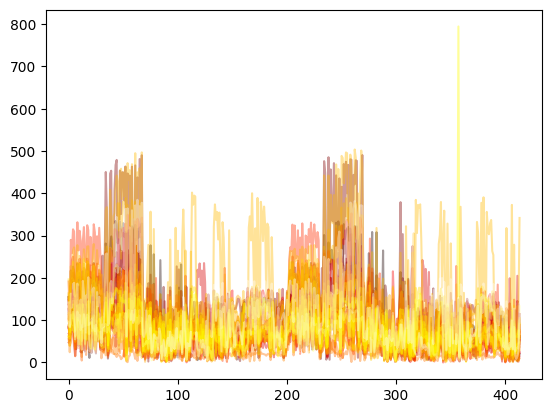

In [159]:
feat = 'cov_total'
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

# for Display
order = np.argsort(psyscore)
ordered_grads = [supermovie_dist[subj] for subj in subjects]
G, coloring = [],[]

colors = plt.cm.hot(np.linspace(0,1,int(max(psyscore))+1))
for i in order:
    plt.plot(np.arange(414), ordered_grads[i], color=colors[int(psyscore[i])], alpha=0.4)

#### Regress / Predictive

Prediction Initial statistics

In [ ]:
n_iter = 300
lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

# across all pidx
np.random.seed(99)
pred_corrs = {"movie": {}, "rest":{}}
null_corrs = {"movie": {}, "rest":{}}
grads_dist = [supermovie_dist, rest_dist]
for gidx, gtype in enumerate(['movie', 'rest']):
    for feat in tqdm(existing_psy):
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

        X = np.asarray([grads_dist[gidx][subj] for subj in subjects])
        y = np.array(deepcopy(psyscore))
        yshuffle = deepcopy(y)
        np.random.shuffle(yshuffle)
        
        pred_corrs[gtype][feat] = compute_outer_fold(X,y, n_iter, lambda_grid, scoring_method)
        null_corrs[gtype][feat] = compute_outer_fold(X,yshuffle, n_iter, lambda_grid, scoring_method)

save('./resources/regression_logs/supermovie-rest_lasso_bis.pkl', pred_corrs)

hide()

  0%|          | 0/15 [00:00<?, ?it/s]

Null model for pairwise comparison of non movie and rest

In [187]:
null_iter = 1 # number of times we generate differences of shuffled feature vectors
n_iter = 1 # number of different folds we select
lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

# across all pidx
np.random.seed(99)
non_param_corrs = {"S1": {feat:[] for feat in existing_psy},
                  "S2": {feat:[] for feat in existing_psy}}

grads_dist = [supermovie_dist, rest_dist]

for _ in range(null_iter):
    for feat in tqdm(existing_psy):
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
        y = np.array(deepcopy(psyscore))
        
        Xmovie = np.asarray([grads_dist[0][subj] for subj in subjects])
        Xrest = np.asarray([grads_dist[1][subj] for subj in subjects])
        X = [Xmovie, Xrest]
        
        # shuffle across subjects and split into 2
        array_index = np.concatenate([np.zeros(len(subjects)), np.ones(len(subjects))])
        array_index = array_index.astype(int)
        np.random.shuffle(array_index)
        X_S1 = []
        X_S2 = []
        for aidx in range(len(subjects)):
            idx1 = array_index[aidx]
            idx2 = array_index[len(subjects) + aidx]
            X_S1.append(X[idx1][aidx])
            X_S2.append(X[idx2][aidx])

        S1 = compute_outer_fold(np.asarray(X_S1), y, n_iter, lambda_grid, scoring_method)
        S2 = compute_outer_fold(np.asarray(X_S2), y, n_iter, lambda_grid, scoring_method)
        
        non_param_corrs['S1'][feat].append(S1)
        non_param_corrs['S2'][feat].append(S2)

save('./resources/regression_logs/supermovie-rest_lasso_diff.pkl', non_param_corrs)

hide()

  0%|          | 0/15 [00:00<?, ?it/s]

NameError: name 'non_param_corrs' is not defined

In [86]:
# pred_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')

In [87]:
pred_df = {"type": [], "pidx": [], "corr": []}
for _type in ['movie','rest']:
    for feat in existing_psy:
        fold_pred = np.abs(np.asarray(pred_corrs[_type][feat]).mean(axis=1))
        
        pred_df['type'] += [_type] * len(fold_pred)
        pred_df['pidx'] += [feat] * len(fold_pred)
        pred_df['corr'] += list(fold_pred)

pred_df = pd.DataFrame.from_dict(pred_df)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DASS_dep_movie vs. DASS_dep_rest: Custom statistical test, P_val:2.423e-08
cov_total_movie vs. cov_total_rest: Custom statistical test, P_val:2.252e-01
DASS_anx_movie vs. DASS_anx_rest: Custom statistical test, P_val:2.669e-30
DASS_str_movie vs. DASS_str_rest: Custom statistical test, P_val:7.448e-02
bas_d_movie vs. bas_d_rest: Custom statistical test, P_val:2.817e-19
bas_f_movie vs. bas_f_rest: Custom statistical test, P_val:5.302e-30
bas_r_movie vs. bas_r_rest: Custom statistical test, P_val:6.312e-03


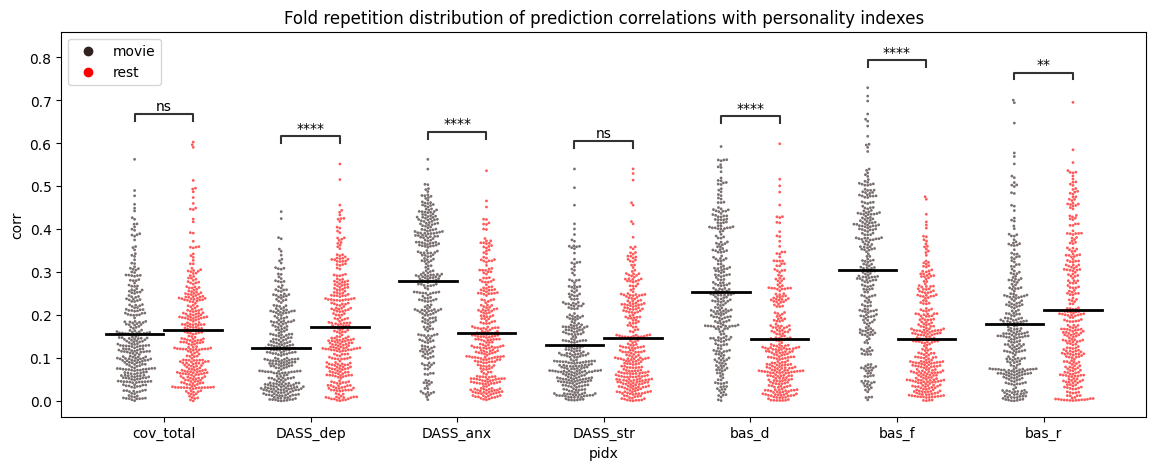

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BIG5_ext_movie vs. BIG5_ext_rest: Custom statistical test, P_val:6.447e-05
bis_movie vs. bis_rest: Custom statistical test, P_val:7.877e-06
BIG5_agr_movie vs. BIG5_agr_rest: Custom statistical test, P_val:6.872e-05
BIG5_con_movie vs. BIG5_con_rest: Custom statistical test, P_val:8.650e-19
BIG5_neu_movie vs. BIG5_neu_rest: Custom statistical test, P_val:1.200e-03
BIG5_ope_movie vs. BIG5_ope_rest: Custom statistical test, P_val:7.550e-13
erq_cr_movie vs. erq_cr_rest: Custom statistical test, P_val:1.003e-02
erq_es_movie vs. erq_es_rest: Custom statistical test, P_val:9.293e-07


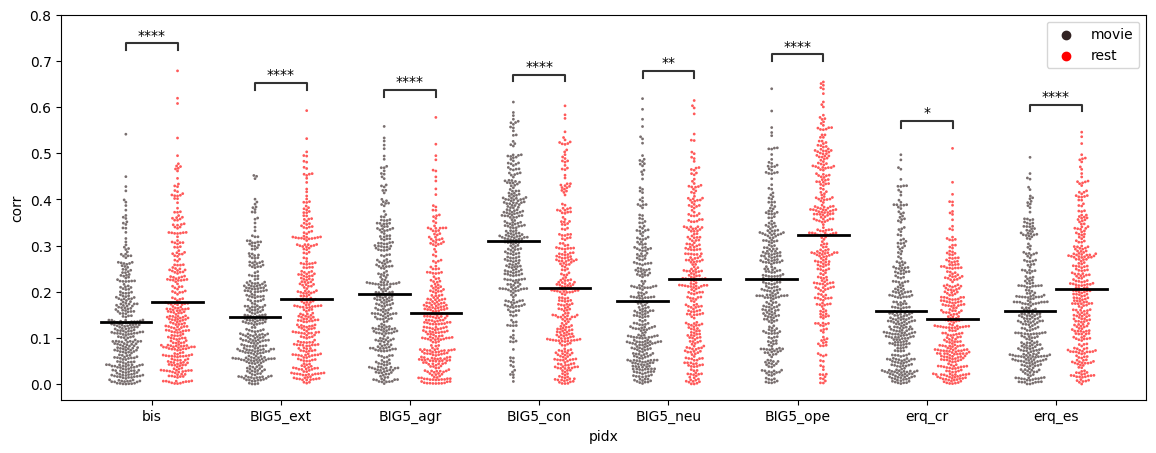

In [124]:
cur_df = pred_df

# Plot 1
plt.figure(figsize=(14,5))

p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)


plotting_parameters = { 'data':    cur_df[cur_df['pidx'].isin(psy1)],'x':'pidx',
                       'y':'corr','hue':'type','palette': sns.color_palette(['black', 'red'])}

# paired t-test
pvalues = []
pairs = []
for psy_p in psy1:
    tmp = cur_df[cur_df['pidx'] == psy_p]
    arr1 = np.nan_to_num(list(tmp[tmp['type']=='movie']['corr']))
    arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))
    pval = stats.ttest_rel(arr1, arr2).pvalue
    pvalues.append(pval)
    pairs.append(((psy_p,'movie'), (psy_p, 'rest')))
    
annotator = Annotator(p, pairs, **plotting_parameters)
annotator.set_pvalues(pvalues)
annotator.annotate()

# get rid of duplicate legends
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])
plt.title("Fold repetition distribution of prediction correlations with personality indexes")
plt.show()



# Plot 2
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)


plotting_parameters = { 'data':    cur_df[cur_df['pidx'].isin(psy2)],'x':'pidx',
                       'y':'corr','hue':'type','palette': sns.color_palette(['black', 'red'])}

# paired t-test
pvalues = []
pairs = []
for psy_p in psy2:
    tmp = cur_df[cur_df['pidx'] == psy_p]
    arr1 = np.nan_to_num(list(tmp[tmp['type']=='movie']['corr']))
    arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))
    pval = stats.ttest_rel(arr1, arr2).pvalue
    pvalues.append(pval)
    pairs.append(((psy_p,'movie'), (psy_p, 'rest')))

        
annotator = Annotator(p, pairs, **plotting_parameters)
annotator.set_pvalues(pvalues)
annotator.annotate()
    
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])
plt.show()

<a class="anchor" id="fselect-staticgrad"></a>
## On frame selected Static Gradients

In [125]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

In [126]:
fselect_supermovie_grads = load('./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl')

In [127]:
subjects = list(fselect_supermovie_grads[0][(0,5)].keys())
nsub = len(subjects)

# extract from all gradients the parcel wise distance to centroid as feature
fselect_supermovie_dists = {}
for fa_nb in range(3):
    tmp_fa = fselect_supermovie_grads[fa_nb]
    per_bound = {}
    for bound in tmp_fa:
        tmp_bounds = tmp_fa[bound]
        
        tmp_dist = {}
        for _id in subjects:
            tmp_grads = tmp_bounds[_id]
            dist = D(tmp_grads.mean(axis=0), tmp_grads)
            tmp_dist[_id] = dist
            
        per_bound[bound] = tmp_dist

    fselect_supermovie_dists[fa_nb] = per_bound

#### Visual difference

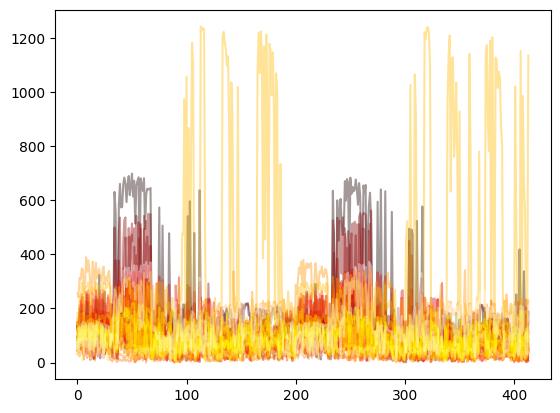

In [128]:
feat = 'cov_total'
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
eg_dist = fselect_supermovie_dists[0][(0,5)]

# for Display
order = np.argsort(psyscore)
ordered_grads = [eg_dist[subj] for subj in subjects]
G, coloring = [],[]

colors = plt.cm.hot(np.linspace(0,1,int(max(psyscore))+1))
for i in order:
    plt.plot(np.arange(414), ordered_grads[i], color=colors[int(psyscore[i])], alpha=0.4)

#### Regress / Predictive

In [136]:
# # across all FA(s)
# for fa_nb in range(3):
#     tmp_fa = fselect_supermovie_dists[fa_nb]
    
#     pred_corrs = {key: {} for key in s25+s33+s50}
#     for gidx, gtype in enumerate(tqdm(pred_corrs.keys())):
        
#         # across all pidx
#         for feat in tqdm(existing_psy):
#             psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

#             X = np.asarray([tmp_fa[gtype][subj] for subj in subjects])
#             y = np.array(deepcopy(psyscore))

#             # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
#             n_iter = 250 #number of repetitions of nested cross val
#             list_scores = []

#             # search grid for hyper parameter
#             lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]
            
#             # Main: cross val Scoring
#             for k in range(n_iter):
#                 rs = k
#                 # configure the cross-validation procedure
#                 cv_inner = KFold(n_splits=4, shuffle=True, random_state=rs)
#                 # define the model
#                 model = Lasso()
#                 # define search space
#                 space = dict()
#                 space['alpha'] = lambda_grid
#                 # define search
#                 search = GridSearchCV(model, space, scoring=scoring_method, n_jobs=1, cv=cv_inner, refit=True)
#                 # configure the cross-validation procedure
#                 cv_outer = KFold(n_splits=3, shuffle=True, random_state=rs)
#                 # execute the nested cross-validation
#                 scores = cross_val_score(search, X, y, scoring=scoring_method, cv=cv_outer, n_jobs=-1)
#                 # report performance
#                 list_scores.append(scores)

#             pred_corrs[gtype][feat] = list_scores

#     save('./resources/regression_logs/fselect_fa{}_lasso_bis.pkl'.format(fa_nb), pred_corrs)

hide()

In [129]:
pred_corrs = load('./resources/regression_logs/fselect_fa2_lasso_bis.pkl')

In [130]:
stand_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')

In [131]:
pred_df = {"type": [], "pidx": [], "corr": []}
for _type in s33:
    for feat in existing_psy:
        fold_pred = np.abs(np.asarray(pred_corrs[_type][feat]).mean(axis=1))
        
        pred_df['type'] += [_type] * len(fold_pred)
        pred_df['pidx'] += [feat] * len(fold_pred)
        pred_df['corr'] += list(fold_pred)

# add rest and movie as a baseline
for _type in ['movie','rest']:
    for feat in existing_psy:
        fold_pred = np.abs(np.asarray(stand_corrs[_type][feat]).mean(axis=1))
        
        pred_df['type'] += [_type] * len(fold_pred)
        pred_df['pidx'] += [feat] * len(fold_pred)
        pred_df['corr'] += list(fold_pred)

pred_df = pd.DataFrame.from_dict(pred_df)

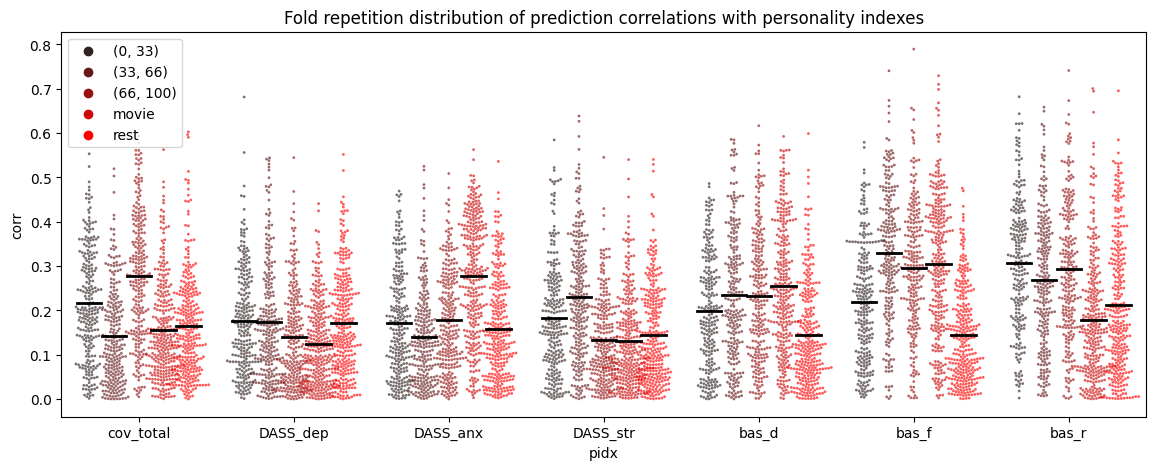

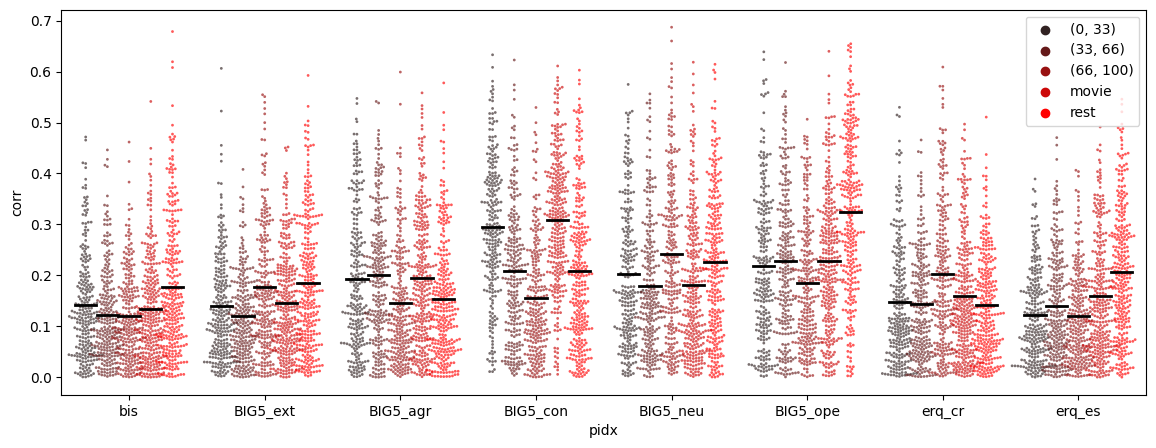

In [134]:
cur_df = pred_df
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2], prop={'size': 10})

plt.title("Fold repetition distribution of prediction correlations with personality indexes")
plt.show()

plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)

# plot the mean line
tmp = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2], prop={'size': 10})

plt.show()

<a class="anchor" id="fselect-staticgrad"></a>
## On frame selected Network-subset Gradients (with baseline per network of Movie and Film)

In [73]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

In [74]:
fselect_supermovie_grads = load('./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl')

In [75]:
subjects = list(fselect_supermovie_grads[0][next(iter(fselect_supermovie_grads[0]))].keys())
nsub = len(subjects)

# extract from all gradients the parcel wise distance to centroid as feature
fselect_supermovie_dists = {}
for fa_nb in range(3):
    tmp_fa = fselect_supermovie_grads[fa_nb]
    per_bound = {}
    for bound in tmp_fa:
        tmp_bounds = tmp_fa[bound]
        
        tmp_dist = {}
        for _id in subjects:
            tmp_grads = tmp_bounds[_id]
            dist = D(tmp_grads.mean(axis=0), tmp_grads)
            tmp_dist[_id] = dist
            
        per_bound[bound] = tmp_dist

    fselect_supermovie_dists[fa_nb] = per_bound

#### Regress / Predictive

In [135]:
# # across all FA(s)
# for fa_nb in range(1,2):
#     tmp_fa = fselect_supermovie_dists[fa_nb]
    
#     # across all networks:
#     for net in index2region17:
#         pred_corrs = {key: {} for key in s20+s25+s33+s50}
#         for gidx, gtype in enumerate(tqdm(pred_corrs.keys())):
#             # across all pidx
#             for feat in tqdm(existing_psy):
            
#                 psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

#                 # features selected per network
#                 X = np.asarray([tmp_fa[gtype][subj][index2region17[net]] for subj in subjects])
#                 y = np.array(deepcopy(psyscore))

#                 # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
#                 n_iter = 250 #number of repetitions of nested cross val
#                 list_scores = []

#                 # search grid for hyper parameter
#                 lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

#                 # Main: cross val Scoring
#                 for k in range(n_iter):
#                     rs = k
#                     # configure the cross-validation procedure
#                     cv_inner = KFold(n_splits=4, shuffle=True, random_state=rs)
#                     # define the model
#                     model = Lasso()
#                     # define search space
#                     space = dict()
#                     space['alpha'] = lambda_grid
#                     # define search
#                     search = GridSearchCV(model, space, scoring=scoring_method, n_jobs=1, cv=cv_inner, refit=True)
#                     # configure the cross-validation procedure
#                     cv_outer = KFold(n_splits=3, shuffle=True, random_state=rs)
#                     # execute the nested cross-validation
#                     scores = cross_val_score(search, X, y, scoring=scoring_method, cv=cv_outer, n_jobs=-1)
#                     # report performance
#                     list_scores.append(scores)

#                 pred_corrs[gtype][feat] = list_scores

#         save('./resources/regression_logs/network_wise/fselect_fa{}_{}_lasso.pkl'.format(fa_nb,net), pred_corrs)

hide()

In [140]:
pred_selects = {}
for net in index2region17:
    pred_selects[net] = load('./resources/regression_logs/network_wise/fselect_fa1_{}_lasso.pkl'.format(net))

In [145]:
pred_df = {"type": [], "pidx": [], "corr": [], "net": []}
for net in index2region17:
    for _type in s25:
        for feat in existing_psy:
            fold_pred = np.abs(np.asarray(pred_corrs[_type][feat]).mean(axis=1))

            pred_df['type'] += [_type] * len(fold_pred)
            pred_df['pidx'] += [feat] * len(fold_pred)
            pred_df['corr'] += list(fold_pred)
            pred_df['net'] += [net] * len(fold_pred)

# # add rest and movie as a baseline
# for _type in ['movie','rest']:
#     for feat in existing_psy:
#         fold_pred = np.abs(np.asarray(stand_corrs[_type][feat]).mean(axis=1))
        
#         pred_df['type'] += [_type] * len(fold_pred)
#         pred_df['pidx'] += [feat] * len(fold_pred)
#         pred_df['corr'] += list(fold_pred)

pred_selects_df = pd.DataFrame.from_dict(pred_df)

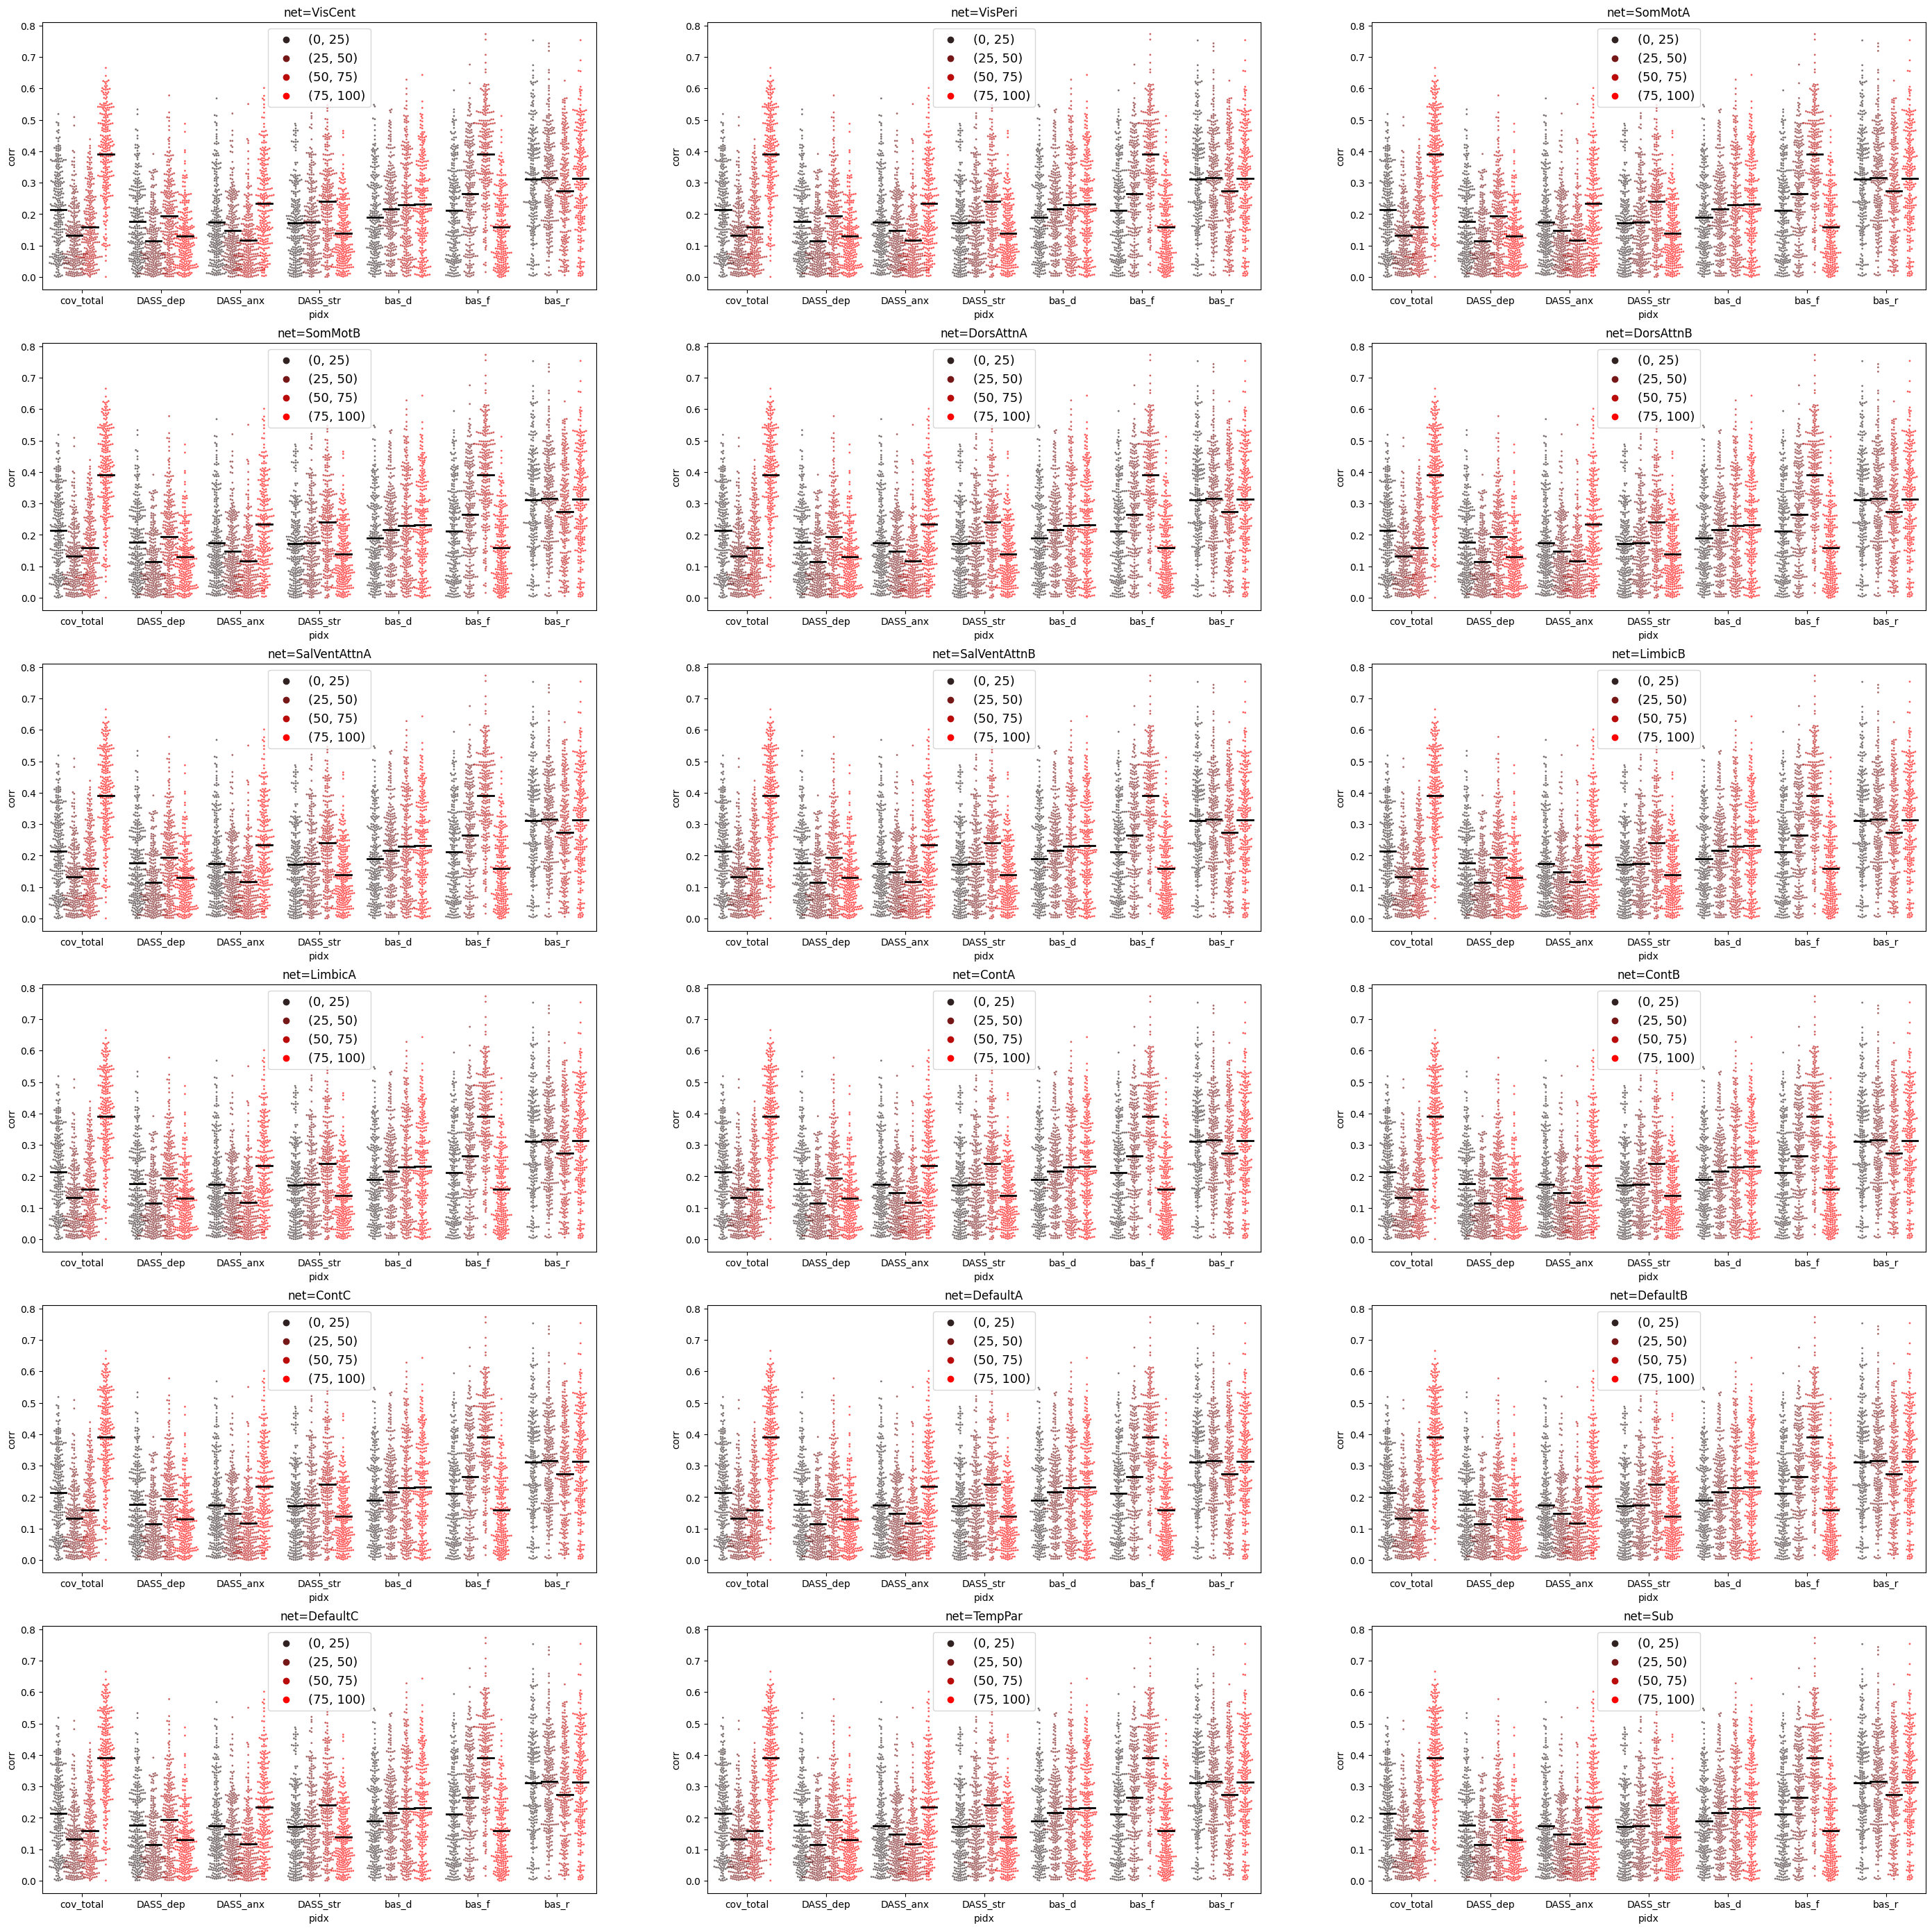

In [152]:
fig, ax = plt.subplots(6,3, figsize=(35,35))
cur_df = pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])]

for idx,net in enumerate(tqdm(index2region17)):
    r,c = idx//3,idx%3
    p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['net']==net], hue="type",
                  color="r", alpha=.65, size=2, dodge=True, ax=ax[r,c])

    # plot the mean line
    sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                x="pidx",
                y="corr", hue="type",
                data=cur_df[cur_df['net']==net],
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)
    handles, labels = p.get_legend_handles_labels()
    p.legend(handles[:len(handles)//2], labels[:len(handles)//2], prop={'size':13})
    
#     ax[r,c].axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
    ax[r,c].set_title('net={}'.format(net))
    
plt.show()

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(35,35))
cur_df = pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])]

for idx,net in enumerate(tqdm(index2region17)):
    r,c = idx//3,idx%3
    p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['net']==net], hue="type",
                  color="r", alpha=.65, size=2, dodge=True, ax=ax[r,c])

    # plot the mean line
    sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                x="pidx",
                y="corr", hue="type",
                data=cur_df[cur_df['net']==net],
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)
    handles, labels = p.get_legend_handles_labels()
    p.legend(handles[:len(handles)//2], labels[:len(handles)//2], prop={'size':13})
    
#     ax[r,c].axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
    ax[r,c].set_title('net={}'.format(net))
    
plt.show()